# Localization - Create Inputs and Outputs

In [1]:
import numpy as np
from PIL import Image
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [52]:
def tprint(*tensors):
    sess = K.get_session()
    for tensor in tensors:
        print(tensor.eval(session=sess))
        print()

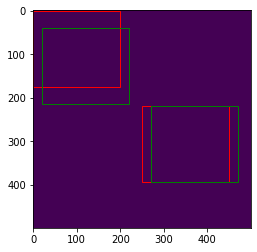

In [2]:
imwidth = 200
imheight = 175
im = np.ones((500, 500))

# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(im)

# Create a Rectangle patch
gt1 = patches.Rectangle(xy=(0,0),
                         width=imwidth, height=imheight,
                         linewidth=1,edgecolor='r',facecolor='none')
# Create a Rectangle patch
pred1 = patches.Rectangle(xy=(20,40),
                         width=imwidth, height=imheight,
                         linewidth=1,edgecolor='g',facecolor='none')
# Create a Rectangle patch
gt2 = patches.Rectangle(xy=(250,220),
                         width=imwidth, height=imheight,
                         linewidth=1,edgecolor='r',facecolor='none')
# Create a Rectangle patch
pred2 = patches.Rectangle(xy=(270,220),
                         width=imwidth, height=imheight,
                         linewidth=1,edgecolor='g',facecolor='none')

# Add the patch to the Axes
ax.add_patch(gt1)
ax.add_patch(pred1)
ax.add_patch(gt2)
ax.add_patch(pred2)

plt.show()

In [3]:
def get_corners(rect):
    return [rect.get_x(), rect.get_y(), rect.get_x() + rect.get_width(), rect.get_y() + rect.get_height()]

In [4]:
preds = [get_corners(pred1), get_corners(pred2)]
gts = [get_corners(gt1), get_corners(gt2)]
print("Preds: ", preds, "GTs: ", gts)

Preds:  [[20, 40, 220, 215], [270, 220, 470, 395]] GTs:  [[0, 0, 200, 175], [250, 220, 450, 395]]


In [50]:
sess = K.get_session()
pred_tensor = tf.cast(tf.convert_to_tensor(preds), tf.float32)
gt_tensor = tf.cast(tf.convert_to_tensor(gts), tf.float32)
print("Pred Tensor: ", pred_tensor, "GT Tensor: ", gt_tensor)

Pred Tensor:  Tensor("Cast_4:0", shape=(2, 4), dtype=float32) GT Tensor:  Tensor("Cast_5:0", shape=(2, 4), dtype=float32)


## IOU

In [51]:
def bbox_iou(x1_1, y1_1, x1_2, y1_2, 
             x2_1, y2_1, x2_2, y2_2):
    x_in_1 = max(x1_1, x2_1)
    y_in_1 = max(y1_1, y2_1)
    x_in_2 = min(x1_2, x2_2)
    y_in_2 = min(y1_2, y2_2)
    intersection = max(abs(x_in_2 - x_in_1), 0) * max(abs(y_in_2 - y_in_1), 0)
    union = (x1_2 - x1_1)*(y1_2 - y1_1) + (x2_2 - x2_1)*(y2_2 - y2_1) - intersection
    return intersection/union
pred = preds[0]
gt = gts[0]
print(pred, gt)
bbox_iou(pred[0], pred[1], pred[2], pred[3], gt[0], gt[1], gt[2], gt[3])

[20, 40, 220, 215] [0, 0, 200, 175]


0.5317286652078774

In [53]:
def tensor_area(min_x, min_y, max_x, max_y):
     return tf.multiply(tf.abs(tf.subtract(max_x, min_x)), 
                        tf.abs(tf.subtract(max_y, min_y)))

In [54]:
def tf_iou(pred_tensor, gt_tensor):
    # Split up input tensors to get desired points
    min_x_pred, min_y_pred, max_x_pred, max_y_pred = tf.split(pred_tensor, pred_tensor.get_shape()[1], axis=1)
    min_x_true, min_y_true, max_x_true, max_y_true = tf.split(gt_tensor, gt_tensor.get_shape()[1], axis=1)
    # Compute Intersection points
    min_x_inter = tf.maximum(min_x_pred, min_x_true)
    min_y_inter = tf.maximum(min_y_pred, min_y_true)
    max_x_inter = tf.minimum(max_x_pred, max_x_true)
    max_y_inter = tf.minimum(max_y_pred, max_y_true)
    # Compute intersection and union areas
    inter_area = tensor_area(min_x_inter, min_y_inter, max_x_inter, max_y_inter)
    union_area = tensor_area(min_x_pred, min_y_pred, max_x_pred, max_y_pred) + tensor_area(min_x_true, min_y_true, max_x_true, max_y_true) - inter_area
    # Return IOU
    return tf.divide(inter_area, union_area)
tprint(tf_iou(pred_tensor, gt_tensor))

[[0.5317287]
 [0.8181818]]



## Smooth L1 Loss
The equation for smooth-L1 loss is as follows:
$$
\begin{align}
    smooth_{L1}(x) = 
    \begin{cases}
    0.5x^2 & |x| < 1 \\
    |x|-0.5 & \text{otherwise}
    \end{cases}
    .
\end{align}
$$
- Smooth L1-loss combines the advantages of L1-loss and L2-loss:
    - L1-loss: steady gradients for large values of x
    - L2-loss: less oscillations during updates when x is small
- Total localization loss function (for SSD at least) is calculated as follows:
$$
\begin{align}
    L_{loc}(gt, pred) = \sum smooth_{L1}(gt, pred)
\end{align}
$$
- **Note:** SSD specifically does not use the 4 corners of the box (like we will below) - Instead it uses:
    - (x, y) coordinates of the top-left of the box (min_x, min_y)
    - logarithms of the height, and width
    - This is the same as how Fast R-CNN does it

In [59]:
def tf_smooth_l1(pred_tensor, gt_tensor):
    # Order here doesn't matter - the loss uses abs(x), and x^2
    abs_dist = tf.abs(tf.subtract(pred_tensor, gt_tensor))
    l1_loss = tf.subtract(abs_dist, 0.5)
    l2_loss = tf.multiply(tf.square(abs_dist), 0.5)
    return tf.where(tf.greater_equal(abs_dist, 1), l1_loss, l2_loss)
tprint(tf_smooth_l1(pred_tensor, gt_tensor))

[[19.5 39.5 19.5 39.5]
 [19.5  0.  19.5  0. ]]

